In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
from astropy.io import fits
import astropy.units as u
import h5py
from astropy.utils.console import ProgressBar
from astropy.coordinates import SkyCoord, Angle
from aesop import EchelleSpectrum
import os

In [2]:
root_dir = '/Users/bmmorris/data/'
target_paths = [os.path.abspath(os.path.join(root_dir, p)) 
                for p in open('target_paths.txt').read().splitlines()]
spectrum_indices = [p.split('.wfrmcpc')[0][-4:] for p in target_paths]

validated_paths = []

for path in target_paths: 
    try: 
        _ = fits.getheader(path)
        validated_paths.append(path)
    except OSError: 
        print(path)

target_names = [(fits.getheader(p)['OBJNAME'].replace(' ', '').replace('-', '')
                 .replace('+', '').replace('_', ''))
                for p in validated_paths]

In [3]:
from astroquery.simbad import Simbad

s = Simbad()
s.add_votable_fields('flux(V)')
s.add_votable_fields('sptype')

WR124
KIC 9652680
KIC9652680
GJ 9781A
HAT P-11
HD 209290
HD 220182
HD 222107
HD34411
HD39587
HD41593
HD45088
HD68017
HD86728
HD110833
HD 266611
HD47752
HD 79555
HD  82106
HD87884
HD98230


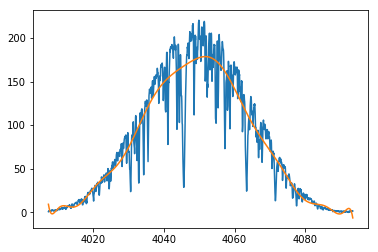

EK Dra
EQ Vir
GJ 705
HAT-P-11
HD 145675
HD 145742
HD 73667
61CygA
61CygB
Kepler-17
Kepler-63
51 Peg
GJ 4099
GJ4099
HD 178126
HD 182488
HD 210277
HR 8832
sigma Draconis
HD 14039
HD221639
HD 113827
HD 122120
HD127506
HD 129333
HD134319
HD 88230
GJ702B
HD148467
HD149957
HD151288
HD175742
HD200560
HD 10697
HD 38230
HD 42250
HD 50692
HD 5857
HD62613
HD 6497
HD 67767
HD 89744
EPIC 211928486
EPIC 211966629
EPIC211928486
EPIC211966629
HR 3454
HR 6943
HR5501
BD28_4211


In [5]:
#archive.close() 
archive = h5py.File('../arcesetc/data/archive.hdf5', 'w')

poly_order = 15

for target_path, target_name in zip(target_paths, target_names):
    target_spectrum = EchelleSpectrum.from_fits(target_path)
    object_name = target_spectrum.header['OBJNAME']

    if object_name not in list(archive) and target_name != 'sky': 
        print(object_name)
        n_orders = len(target_spectrum.spectrum_list)
        if object_name == 'BD28_4211': 
            object_name = 'BD+28 4211'

        dset = archive.create_dataset(object_name, shape=(n_orders, 3+poly_order+1))

        query = s.query_object(object_name)
        v_mag = query['FLUX_V']
        sptype = query['SP_TYPE']
        dset.attrs['V'] = v_mag
        
        if object_name == '61CygA':
            dset.attrs['V'] = [5.21]
        elif object_name == '61CygB':
            dset.attrs['V'] = [6.03]
        elif object_name == 'Kepler-17':
            dset.attrs['V'] = [14.0]
        
        dset.attrs['SP_TYPE'] = str(sptype).split('\n')[2].strip()
        dset.attrs['NAME'] = object_name

        matrix = []
        for order in np.arange(n_orders):
            
            wave, flux = target_spectrum[order].wavelength, target_spectrum[order].flux/target_spectrum.header['EXPTIME']
            polynomial_coefficients = np.polyfit(wave - wave.mean(), flux, poly_order)

            matrix.append(np.concatenate([[wave.value.mean(), np.median(np.diff(wave.value)), len(wave)], 
                                          polynomial_coefficients]))
            if target_name == 'HD98230' and order == 20:
                plt.plot(wave, flux)
                plt.plot(wave, np.polyval(polynomial_coefficients, wave - wave.mean()))
                plt.show()

        dset[:] = np.array(matrix)
archive.close()

In [6]:
archive = h5py.File('../arcesetc/data/archive.hdf5', 'r+')
sptype_dictionary = dict()

for target in archive:
    dset = archive[target]
    sptype = dset.attrs['SP_TYPE']
    if len(sptype) > 0:  
        sptype_dictionary[sptype] = dset.attrs['NAME']
    elif target == '61CygA': 
        sptype_dictionary['K5V'] = dset.attrs['NAME']
    elif target == '61CygB': 
        sptype_dictionary['K7V'] = dset.attrs['NAME']

from json import dump
dump(sptype_dictionary, open('../arcesetc/data/sptype_dict.json', 'w'))

In [7]:
for target in archive: 
    print(target, archive[target].attrs['V'], archive[target].attrs['SP_TYPE'])

51 Peg [5.46] G2IV
61CygA [5.21] 
61CygB [6.03] 
BD+28 4211 [10.58] sdO2VIIIHe5
EK Dra [7.61] G1.5V
EPIC 211928486 [13.52] K5V
EPIC 211966629 [13.26] K4V
EPIC211928486 [13.52] K5V
EPIC211966629 [13.26] K4V
EQ Vir [9.372] K5Ve
GJ 4099 [11.36] M2.0Ve
GJ 705 [8.17] K2
GJ 9781A [9.02] K7
GJ4099 [11.36] M2.0Ve
GJ702B [6.07] K4V
HAT P-11 [9.47] K4V
HAT-P-11 [9.47] K4V
HD  82106 [7.197] K3V
HD 10697 [6.279] G3Va
HD 113827 [9.391] K4V
HD 122120 [9.04] K5V
HD 129333 [7.61] G1.5V
HD 14039 [8.27] K1V
HD 145675 [6.67] K0V
HD 145742 [7.55] K0
HD 178126 [9.215] K5V
HD 182488 [6.356] K0V
HD 209290 [9.146] M0.5V
HD 210277 [6.63] G8V
HD 220182 [7.36] G9V
HD 222107 [3.82] G8IVk
HD 266611 [9.745] K5V
HD 38230 [7.36] K0V
HD 42250 [7.43] G9V
HD 50692 [5.748] G0V
HD 5857 [8.92] G5
HD 6497 [6.401] K2III-IV
HD 67767 [5.73] G7V
HD 73667 [7.582] K2V
HD 79555 [7.925] K4V
HD 88230 [6.61] K6VeFe-1
HD 89744 [5.72] F7V
HD110833 [7.04] K3V
HD127506 [8.97] K3.5V
HD134319 [8.41] G5V:
HD148467 [8.85] K6V
HD149957 [9.465